# MultiTag Predictor

### Importing Data and Text preprocessing

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Varun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [5]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [6]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [7]:
#Removing Stopwords and Bad Symbols

In [8]:
import re

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = ' '.join([str.lower() for str in text.split()])
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)
    text = re.sub(BAD_SYMBOLS_RE,'',text)
    text = ' '.join(str for str in text.split() if str not in STOPWORDS)
    return text

In [10]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [11]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [12]:
# Creating Dictionaries for all the tags and words with their counts.

In [13]:
tags_counts = {}
words_counts = {}

from collections import Counter,defaultdict
tags_counts = Counter([item for sublist in y_train for item in sublist])
words_counts = Counter([item for sublist in X_train for item in sublist.split()])

In [14]:
# Top 3 most common tags and words

In [15]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

# Feature Extraction

### Bag of Words Approach

In [16]:
#Transforming text to a one-hot-encoded feature vector a.k.a Bag of Words Representation

In [17]:
DICT_SIZE = 5000
top_5000_words= sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = defaultdict(lambda :0)
INDEX_TO_WORDS = []

for i in range(DICT_SIZE):
    WORDS_TO_INDEX[top_5000_words[i][0]]=i
    INDEX_TO_WORDS.append(top_5000_words[i][0])
    
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    list_of_words=text.split()
    for i in range(len(text.split())):
        if(list_of_words[i] in words_to_index):
            result_vector[words_to_index[list_of_words[i]]]=1
    return result_vector

In [18]:
from scipy import sparse as sp_sparse

In [19]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [20]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

print(non_zero_elements_count)

7


### TF-IDF Approach

In [21]:
#Creating Tf-Idf Matrix

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=5,token_pattern='\S+',ngram_range=(1,2),norm='l2')
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [24]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [25]:
tfidf_vocab['c#']

1879

# MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

In [27]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [28]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
#In this task I am using One-vs-Rest approach, which is implemented in OneVsRestClassifier

In [30]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [31]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    trained_classifier=OneVsRestClassifier(LogisticRegression()).fit(X_train, y_train)
    
    return trained_classifier

In [32]:
# Training the classifiers for bot bag-of-words and tf-idf representations.

In [33]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

## Predictions

In [34]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [35]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




### Evaluation

To evaluate the results following are the several classification metrics:
 - Accuracy
 - F1-score
 - Area under ROC-curve
 - Area under precision-recall curve
 

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [37]:
def print_evaluation_scores(y_val, predicted):
    
    print("accuracy-%s"%accuracy_score(y_true=y_val,y_pred=predicted))
    print("f1_score_macro-%s"%f1_score(y_true=y_val,y_pred=predicted,average='macro'))
    print("f1_score_micro-%s"%f1_score(y_true=y_val,y_pred=predicted,average='micro'))
    print("f1_score_weighted-%s"%f1_score(y_true=y_val,y_pred=predicted,average='weighted'))
    print(average_precision_score(y_true=y_val,y_score=predicted,average='macro'))
    print(average_precision_score(y_true=y_val,y_score=predicted,average='micro'))
    print(average_precision_score(y_true=y_val,y_score=predicted,average='weighted'))

In [38]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
accuracy-0.3617
f1_score_macro-0.5079393401644391
f1_score_micro-0.6739590684544814
f1_score_weighted-0.6516950963214964
0.34860492239017654
0.48479788323706385
0.5140436099081112
Tfidf
accuracy-0.33393333333333336
f1_score_macro-0.4456785814747649
f1_score_micro-0.6417936591346997
f1_score_weighted-0.6143301673391723
0.30201027305037553
0.45696893178725534
0.48507917535002937


In [39]:
from metrics import roc_auc
%matplotlib inline

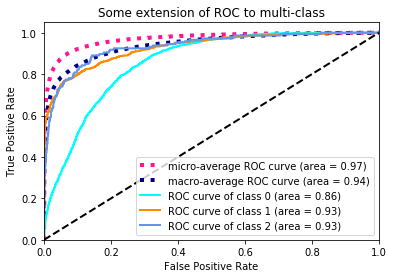

In [40]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

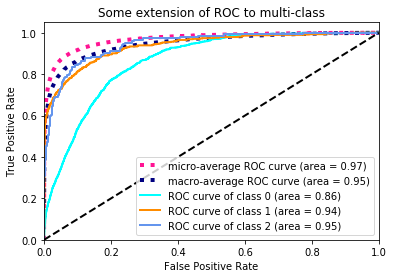

In [41]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [42]:
# Using 'l2' penalty regularization to improve performance

In [43]:
def train_classifier_advanced(X_train, y_train, C):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    print(C)
    trained_classifier=OneVsRestClassifier(LogisticRegression(penalty='l2',C=C)).fit(X_train, y_train)
    
    return trained_classifier

In [44]:
classifier_advanced_mybag_01 = train_classifier_advanced(X_train_mybag, y_train,0.1)
y_val_predicted_labels_mybag_01 = classifier_advanced_mybag_01.predict(X_val_mybag)
print_evaluation_scores(y_val,y_val_predicted_labels_mybag_01)

classifier_advanced_mybag_1 = train_classifier_advanced(X_train_mybag, y_train,1)
y_val_predicted_labels_mybag_1 = classifier_advanced_mybag_1.predict(X_val_mybag)
print_evaluation_scores(y_val,y_val_predicted_labels_mybag_1)

classifier_advanced_mybag_10 = train_classifier_advanced(X_train_mybag, y_train,10)
y_val_predicted_labels_mybag_10 = classifier_advanced_mybag_10.predict(X_val_mybag)
print_evaluation_scores(y_val,y_val_predicted_labels_mybag_10)

classifier_advanced_mybag_100 = train_classifier_advanced(X_train_mybag, y_train,100)
y_val_predicted_labels_mybag_100 = classifier_advanced_mybag_100.predict(X_val_mybag)
print_evaluation_scores(y_val,y_val_predicted_labels_mybag_100)

0.1
accuracy-0.3138666666666667
f1_score_macro-0.434602787827507


C:\Users\Varun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score_micro-0.6216016812734753
f1_score_weighted-0.5931802369317988
0.3038051587260352
0.43715782866142294
0.4670627291705929
1
accuracy-0.3617
f1_score_macro-0.5079393401644391
f1_score_micro-0.6739590684544814
f1_score_weighted-0.6516950963214964
0.34860492239017654
0.48479788323706385
0.5140436099081112
10
accuracy-0.3531
f1_score_macro-0.5121080759913282
f1_score_micro-0.6706237344661928
f1_score_weighted-0.6539520216189231
0.33312152252573746
0.47002495466074706
0.5039871783303804
100
accuracy-0.32043333333333335
f1_score_macro-0.47249487723177275
f1_score_micro-0.6454447976103858
f1_score_weighted-0.63446958774756
0.28206312659434596
0.4309859747045016
0.4758574216725836


In [45]:
test_predictions = classifier_advanced_mybag_1.predict(X_test_mybag[0])
test_pred_inversed = mlb.inverse_transform(test_predictions)
print(test_pred_inversed)

[('mysql', 'php')]


### Analysis of the most important features

Finally, let's take a look at top words for each tag.

In [46]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extracting an estimator from the classifier for the given tag. 
    tag_index=tags_classes.index(tag)
    
    # Extracting feature coefficients from the estimator.
    coef_list=classifier_advanced_mybag_1.estimators_[tag_index].coef_[0]
    coef_dict={}
    for i in range(len(coef_list)):
        coef_dict[coef_list[i]]=i
        
    coef_dict_desc=sorted(coef_dict.items(), key=lambda x: x[0], reverse=True)[:5]
    coef_dict_asc=sorted(coef_dict.items(), key=lambda x: x[0], reverse=False)[:5]
    
    top_positive_words = [index_to_words[index[1]] for index in coef_dict_desc]
    top_negative_words = [index_to_words[index[1]] for index in coef_dict_asc]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [47]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	1 2, branching, best, back button, content div
Top negative words:	aes encryption, #1, #ifdef, #pragma, #2

Tag:	c++
Top positive words:	+ mysql, add field, angularjs form, basic net, based application
Top negative words:	#1, #ifdef, #pragma, #2, + c#

Tag:	linux
Top positive words:	access array, blade, c#, code c++, allowed memory
Top negative words:	#ifdef, + c#, #object method, 1 mysqli, + php



### Thanks for reading this document :)